# Labelling Famous Landmarks (Transfer Learning) 

This notebook shows up one of the neural network model implementation for my data science project about the **Google Landmark Recognition 2020** dataset. The main objective with this step is applying transfer learning, carrying on the  hyperparameter tuning of the model and finally evaluating the results.

# Index of Contents

1.   Loading modules and data
2.   Preprocessing data
3.   Model Construction
4.   Evaluation



# Loading modules and data

Since I am using Google Colab, I linked my Google Drive just to access all the data downloaded from Kaggle. Also, by this way all the result and created files are easily stored on my unit.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For the model implementation I will make use of **Keras** library due to its simplicity and large community support.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.applications import VGG16
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip, RandomRotation
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
from tensorboard.plugins.hparams import api as hp
from sklearn.utils import class_weight
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf

# Load the TensorBoard notebook extension
%load_ext tensorboard

Checking the availability of the Google Colab free GPU for the model training.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Extracting all the images from the Google Drive unit with which the model will be feeded.

In [ ]:
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/train_20.zip'
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/val_20.zip'
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/test_20.zip'

Checking is everything is done correctly.

In [ ]:
! ls -a 

.  ..  .config	drive  sample_data  ..test_20  ..train_20  ..val_20


Set a seed to make reproducible experiments.

In [ ]:
seed = 487

In [ ]:
train_csv = pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/train_20.csv")
train_csv.sample(5, random_state=seed)

,id,landmark_id,path
9237,17a1e86863a556f1,9070,../input/landmark-recognition-2020/train/1/7/a...
6912,f2fc05ddadf15704,161902,../input/landmark-recognition-2020/train/f/2/f...
7341,7504c5bf786738e4,46705,../input/landmark-recognition-2020/train/7/5/0...
9591,830eae18313f4d71,176528,../input/landmark-recognition-2020/train/8/3/0...
4910,4590291b1735197d,177870,../input/landmark-recognition-2020/train/4/5/9...


# Preprocessing data

Before starting with the model construction, it is convenient to prepare the data.

In [ ]:
CLASSES = 20
BATCH_SIZE = 512
IMG_SIZE = (128, 128)
DATA_FORMAT = "channels_last"

In [ ]:
train_dir = "..train_20"
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=seed)

val_dir = "..val_20"
val_dataset = image_dataset_from_directory(val_dir,
                                           shuffle=False,
                                           label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=seed)

Found 12605 files belonging to 20 classes.
Found 3556 files belonging to 20 classes.
Found 1796 files belonging to 20 classes.


Let's previsualize some bunch of photos from the train dataset, to check everything is loaded correctly.

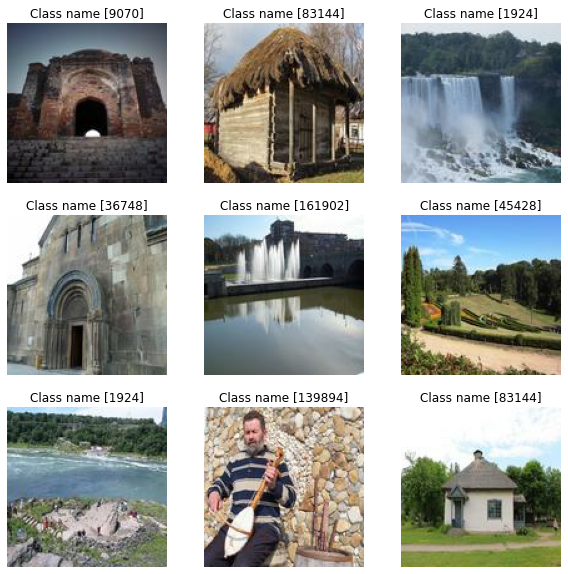

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Class name [{class_names[np.argmax(labels[i])]}]")
    plt.axis("off")

To load images from disk without I/O being blocked and boost the performance, it is highly recommended to use the buffered prefetching feature AUTOTUNE.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation
After several disastrous attempts of training the models with only the original images, I supposed that data augmentation technique could be one of the clues for improving the performance. Although the dataset is big enough, its special characteristic (intra-class variance) make the training process difficult to extract common features. The hypothesis that I came up with is that as every image is unique in each class, the model needs more examples to learn from. So, the idea is to generate on the fly "augmented" images from the original ones to facilitate more similar examples to the network in order to boost its accuracy.

In [ ]:
data_augmentation = Sequential([
      RandomFlip("horizontal"),
      RandomZoom(0.2,0.2),
      RandomRotation(0.2),                          
], name="data_augmentation")

There are different ways of performing data augmentation with Keras, I ahve opted to make use of the experimental preprocessing layers instead of the classical ImageDataGenerator class. Let's see the result with some random photos.

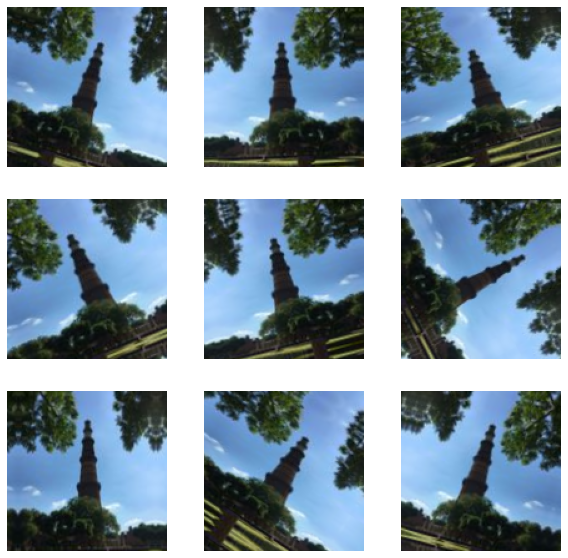

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Another important thing to consider is rescaling the pixel values, so let's create a separate layer for that specific task.

In [ ]:
rescale = Sequential([
      Rescaling(1./255)
], name="rescale")

# Model Construction
Now it is time to build the model and for that I am going to use **Xception** as a base model. It is one of the different pre-trained models available on Keras. This tecnhique is called transfer learning because we are going to take the knowledge extracted from one dataset (ImageNet) and applied it to classify images from our.

The first thing to do is load all the weights and freeze all the layers.

In [ ]:
pretrained_model = VGG16(include_top=False, 
                         weights="imagenet",
                         input_shape=(*IMG_SIZE,3))
pretrained_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


Once created the pretrained model, we need to create the customized layers for our case. This part is known as the top block or classification head. 

In [ ]:
# Create new model on top.
inputs = Input(shape=(*IMG_SIZE,3))
x = rescale(inputs)
x = data_augmentation(x)
x = pretrained_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
x = Flatten(data_format=DATA_FORMAT)(x)
# x = Dense(512, "relu" )(x)
# x = Dropout(0.2)(x)
# x = Dense(512, "relu" )(x)
# x = Dropout(0.5)(x)
outputs = Dense(CLASSES, "softmax")(x)
model = Model(inputs, outputs)

Although the imbalance among classes was reduces on the **Data Cleaning** process, an significant gap stills remaining. The  weights for each class are calculated to make a better balanced and ensure a more accurate update of the neural network weights.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_csv.landmark_id),
                                                 train_csv.landmark_id)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.950603318250377, 1: 0.9972310126582279, 2: 1.1564220183486238, 3: 1.011637239165329, 4: 0.9378720238095238, 5: 1.0700339558573855, 6: 1.1846804511278195, 7: 1.011637239165329, 8: 0.9392697466467959, 9: 0.9392697466467959, 10: 1.0941840277777777, 11: 0.9378720238095238, 12: 0.9378720238095238, 13: 0.9378720238095238, 14: 1.0434602649006623, 15: 1.011637239165329, 16: 1.0941840277777777, 17: 0.9756191950464397, 18: 0.9378720238095238, 19: 0.9392697466467959}


The competition metric is a common point for comparing the results of the model. It is a guide to follow for the tuning process.  

$GAP = \frac{1}{M}\sum_{i=1}^N P(i) rel(i)$ 

While searching how to code the formula I found several implementations, but not all were adapted for being used by Keras. So, I take one that was commonly used on different notebooks:

*   [Landmark Recognition Challenge - jandaldrop](https://github.com/jandaldrop/landmark-recognition-challenge/blob/master/landmarks-xception.ipynb)
*   [TF Keras EffNet B2 - Non Landmark Removal - Robert Smits](https://www.kaggle.com/rsmits/tf-keras-effnet-b2-non-landmark-removal)

The GAP is estimated by calculating it on each batch during training.



In [ ]:
def GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

In [ ]:
metrics = [GAP, "accuracy"]

EPOCHS = 20
LR = 1e-3

model.summary()
model.compile(optimizer=Adam(learning_rate=LR), 
              loss=CategoricalCrossentropy(), 
              metrics=metrics)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescale (Sequential)         (None, 128, 128, 3)       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                163860    
Total params: 14,878,548
Trainable params: 163,860
Non-trainable params: 14,714,688
_________________________________________

To train the model and keep track of what is happening inside this giant black box, it is a common practice to use checkpoints. They allow us to store valious information as the weights of the best models, the track of the metrics and other kind of parameters if they are needed. 

**TensorBoard** needs a special mention because it is a tool that makes things easy for the hyper-parameter tuning and also sharing with the community the results of the different experiments carried on.

In [ ]:
#Dictionary as a log for the hyperparemeter tuning
hyperparameters = { 
    'classes': CLASSES,
    'img_size': IMG_SIZE[0],
    'optimizer': "Adam",
    'batch': BATCH_SIZE,
    'data_augmentation': True,
    'learning_rate': LR,
    'epochs': EPOCHS, 
    'flatten': True,
    'dense': CLASSES
}
hyperparameters

{'batch': 512,
 'classes': 20,
 'data_augmentation': True,
 'dense': 20,
 'epochs': 20,
 'flatten': True,
 'img_size': 128,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
LOG_PATH = "/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_VGG16_feature_extraction.csv"
log_csv = pd.read_csv(LOG_PATH)
print(log_csv.shape)
log_csv

(20, 22)


,batch,classes,data_augmentation,dense,epochs,flatten,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,global_average,dense_1,dropout,dense_2,dropout_1
0,256.0,200.0,0.0,200.0,15.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.997,0.998,0.052,0.386,0.609,1.920,NaN,NaN,NaN,NaN,NaN
1,256.0,200.0,0.0,200.0,15.0,NaN,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.234,0.477,2.449,0.213,0.434,2.627,1.0,NaN,NaN,NaN,NaN
2,256.0,200.0,0.0,200.0,15.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.889,0.943,0.284,0.341,0.569,1.953,NaN,512.0,0.2,NaN,NaN
3,256.0,200.0,0.0,200.0,15.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.959,0.978,0.183,0.386,0.607,1.810,NaN,NaN,0.2,NaN,NaN
4,512.0,200.0,0.0,200.0,15.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.957,0.978,0.236,0.381,0.611,1.727,NaN,NaN,NaN,NaN,NaN
5,512.0,200.0,0.0,200.0,20.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.998,0.999,0.042,0.386,0.614,1.900,NaN,NaN,NaN,NaN,NaN
6,512.0,200.0,0.0,200.0,25.0,1.0,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.999,1.000,0.035,0.388,0.616,1.902,NaN,NaN,NaN,NaN,NaN
7,256.0,200.0,1.0,200.0,15.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.361,0.596,1.663,0.253,0.488,2.265,NaN,NaN,NaN,NaN,NaN
8,256.0,200.0,1.0,200.0,15.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.245,0.491,2.137,0.210,0.435,2.432,NaN,512.0,0.2,NaN,NaN
9,256.0,200.0,1.0,200.0,20.0,1.0,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.223,0.465,2.513,0.204,0.426,2.687,NaN,NaN,0.5,NaN,NaN


In [ ]:
NUM_EXPERIMENT = log_csv.shape[0] #index of the last experiment
LOG_DIR = f"/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs/VGG16_feature_extraction_{NUM_EXPERIMENT}"
CHECK_POINT = f"/content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_feature_extraction_{NUM_EXPERIMENT}.h5"

callbacks = [
      EarlyStopping(monitor="val_accuracy", verbose=1, patience=3, mode="max", restore_best_weights=True), 
      ModelCheckpoint(filepath=CHECK_POINT,verbose=1, monitor="val_accuracy", mode="max", save_best_only=True),
      TensorBoard(log_dir=LOG_DIR, histogram_freq=1),
      hp.KerasCallback(LOG_DIR, hyperparameters)
]

with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                      epochs=EPOCHS,
                      callbacks=callbacks,
                      class_weight=class_weights,
                      validation_data=val_dataset)

Epoch 1/20
25/25 [==============================] - 146s 4s/step - loss: 2.6595 - GAP: 0.0711 - accuracy: 0.2200 - val_loss: 1.6740 - val_GAP: 0.2628 - val_accuracy: 0.5070

Epoch 00001: val_accuracy improved from -inf to 0.50703, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_feature_extraction_20.h5
Epoch 2/20
25/25 [==============================] - 42s 2s/step - loss: 1.6394 - GAP: 0.2860 - accuracy: 0.5283 - val_loss: 1.3833 - val_GAP: 0.3739 - val_accuracy: 0.6108

Epoch 00002: val_accuracy improved from 0.50703 to 0.61080, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_feature_extraction_20.h5
Epoch 3/20
25/25 [==============================] - 41s 2s/step - loss: 1.3883 - GAP: 0.3742 - accuracy: 0.6072 - val_loss: 1.2499 - val_GAP: 0.4172 - val_accuracy: 0.6429

Epoch 00003: val_accuracy improved from 0.61080 to 0.64286, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_feature_extraction_20.h5
Epoch 4/20
25/25 [

In [ ]:
train_loss, train_gap, train_acc = model.evaluate(train_dataset)

25/25 [==============================] - 32s 1s/step - loss: 0.6932 - GAP: 0.6402 - accuracy: 0.8006


In [ ]:
val_loss, val_gap, val_acc = model.evaluate(val_dataset)

7/7 [==============================] - 8s 1s/step - loss: 0.8567 - GAP: 0.5603 - accuracy: 0.7455


In [ ]:
results = {
    'train_loss': round(train_loss,3) ,
    'train_acc': round(train_acc,3),
    'train_GAP': round(train_gap,3),
    'val_loss': round(val_loss,3),
    'val_acc': round(val_acc,3),
    'val_GAP': round(val_gap,3),
    'model': CHECK_POINT,
    'tensorboard': LOG_DIR
}
results

{'model': '/content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_feature_extraction_20.h5',
 'tensorboard': '/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs/VGG16_feature_extraction_20',
 'train_GAP': 0.64,
 'train_acc': 0.801,
 'train_loss': 0.693,
 'val_GAP': 0.56,
 'val_acc': 0.746,
 'val_loss': 0.857}

In [ ]:
log = {}
log.update(hyperparameters)
log.update(results)
# log_csv = pd.DataFrame() #Comment later
log_csv = log_csv.append(log, ignore_index=True)
print(log_csv.shape)
log_csv.to_csv(LOG_PATH, index=False)

(21, 22)


Once the model is trained, let's take a look to its performance through its history. The analysis give us clues about how well the model has learned, if it has overfit or underfit. In other words, it is the proof we have to make changes on the parameters.

In [ ]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  gap = history.history['GAP']
  val_gap = history.history['val_GAP']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(7, 10))
  plt.subplot(3, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy',  linestyle='dashed', color="red")
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(3, 1, 2)
  plt.plot(gap, label='Training GAP')
  plt.plot(val_gap, label='Validation GAP', linestyle='dashed', color="red")
  plt.legend(loc='lower right')
  plt.ylabel('GAP')
  plt.title('Training and Validation GAP')

  plt.subplot(3, 1, 3)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss',  linestyle='dashed', color="red")
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  
  plt.show()

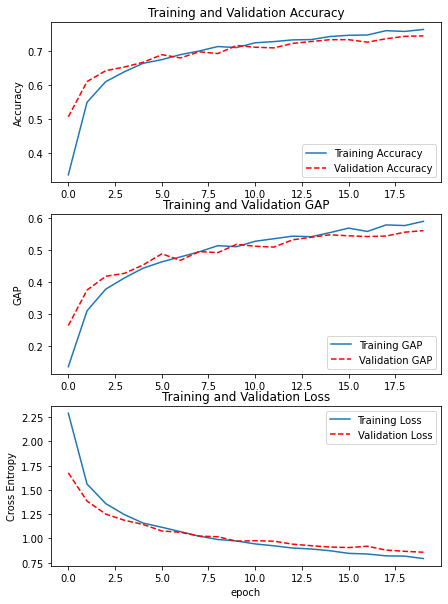

In [ ]:
plot_history(history)

Another way of increasing the performance of the model is performing what is called a **fine-tuning** process. It is a tecnique that trains the weights of the pretrained model, "tuning" them or specializing them to the images of the current database. It is not recommended to unfreeze the entire model, just some of the top layers which are the most specialized.  Rather than overwriting the generic learning, fine-tuning aims to adapt these specialized features to work with the our dataset.

In [ ]:
# Create new model on top.
inputs = Input(shape=(*IMG_SIZE,3))
x = rescale(inputs)
x = data_augmentation(x)
x = pretrained_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
x = Flatten(data_format=DATA_FORMAT)(x)
# x = Dense(512, "relu" )(x)
# x = Dropout(0.2)(x)
# x = Dense(512, "relu" )(x)
# x = Dropout(0.5)(x)
outputs = Dense(CLASSES, "softmax")(x)
model = Model(inputs, outputs)

In [ ]:
pretrained_model.trainable = True

print("Number of layers in the pretrained model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

metrics = [GAP, "accuracy"]

FINE_TUNE_EPOCHS = 50
LR = 1e-4

model.compile(optimizer=RMSprop(learning_rate=LR),  
              loss=CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Number of layers in the pretrained model:  19
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescale (Sequential)         (None, 128, 128, 3)       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                163860    
Total params: 14,878,548
Trainable params: 2,523,668
Non-trainable params: 12,3

In [ ]:
LOG_PATH = "/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_VGG16_fine_tuning.csv"
log_csv = pd.read_csv(LOG_PATH)
print(log_csv.shape)
log_csv

(16, 20)


,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout
0,200,128,256,False,1.000000e-05,RMSprop,35,15,200,True,0.139,0.982,0.966,1.664,0.643,0.427,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
1,200,128,256,False,1.000000e-05,RMSprop,35,16,200,True,0.006,1.000,1.000,1.940,0.675,0.468,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
2,200,128,256,True,1.000000e-05,RMSprop,40,16,200,True,1.273,0.680,0.469,1.743,0.589,0.358,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
3,200,128,256,True,1.000000e-05,RMSprop,45,15,200,True,1.236,0.688,0.478,1.735,0.589,0.365,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
4,200,128,256,True,1.000000e-07,RMSprop,50,16,200,True,1.148,0.709,0.510,1.640,0.608,0.383,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
5,200,128,256,False,1.000000e-05,RMSprop,50,16,200,True,0.703,0.862,0.744,1.573,0.632,0.415,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5
6,200,128,256,False,1.000000e-04,RMSprop,50,16,200,True,0.010,0.999,0.999,1.384,0.712,0.521,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5
7,200,128,256,False,1.000000e-04,RMSprop,50,16,200,True,0.001,1.000,1.000,1.883,0.715,0.522,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
8,20,128,512,False,1.000000e-04,RMSprop,50,15,20,True,0.001,1.000,1.000,0.558,0.877,0.769,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
9,20,128,512,False,1.000000e-06,RMSprop,50,15,20,True,0.001,1.000,1.000,0.580,0.880,0.774,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN


In [ ]:
#Dictionary as a log for the hyperparemeter tuning
hyperparameters = { 
    'classes': CLASSES,
    'img_size': IMG_SIZE[0],
    'batch': BATCH_SIZE,
    'data_augmentation': True,
    'learning_rate': LR,
    'optimizer': "RMSprop",
    'epochs': FINE_TUNE_EPOCHS, 
    'freezed_layers': fine_tune_at,
    'dense': CLASSES,
    'flatten': True
}
hyperparameters

{'batch': 512,
 'classes': 20,
 'data_augmentation': True,
 'dense': 20,
 'epochs': 50,
 'flatten': True,
 'freezed_layers': 17,
 'img_size': 128,
 'learning_rate': 0.0001,
 'optimizer': 'RMSprop'}

In [ ]:
NUM_EXPERIMENT = log_csv.shape[0]
LOG_DIR = f"/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs/VGG16_fine_tuning_{NUM_EXPERIMENT}"
CHECK_POINT = f"/content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_fine_tuning_{NUM_EXPERIMENT}.h5"

callbacks = [
      EarlyStopping(monitor="val_accuracy", verbose=1, patience=5, mode="max", restore_best_weights=True),
      ModelCheckpoint(filepath=CHECK_POINT,verbose=1, monitor="val_accuracy", mode="max", save_best_only=True),
      TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
]

with tf.device('/device:GPU:0'):
  history_fine = model.fit(train_dataset,
                          epochs=FINE_TUNE_EPOCHS,
                          callbacks=callbacks,
                          class_weight=class_weights,
                          validation_data=val_dataset)

Epoch 1/50
25/25 [==============================] - 28s 982ms/step - loss: 0.4294 - GAP: 0.7472 - accuracy: 0.8663 - val_loss: 0.5651 - val_GAP: 0.7120 - val_accuracy: 0.8391

Epoch 00001: val_accuracy improved from -inf to 0.83915, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_fine_tuning_16.h5
Epoch 2/50
25/25 [==============================] - 26s 949ms/step - loss: 0.3623 - GAP: 0.7856 - accuracy: 0.8848 - val_loss: 0.5575 - val_GAP: 0.7185 - val_accuracy: 0.8428

Epoch 00002: val_accuracy improved from 0.83915 to 0.84280, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_fine_tuning_16.h5
Epoch 3/50
25/25 [==============================] - 25s 912ms/step - loss: 0.3526 - GAP: 0.7782 - accuracy: 0.8851 - val_loss: 0.5541 - val_GAP: 0.7202 - val_accuracy: 0.8436

Epoch 00003: val_accuracy improved from 0.84280 to 0.84364, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_fine_tuning_16.h5
Epoch 4/50
25/25 [=============

Again, save the model. Actually this is the latest model, the one that we are going to evaluate later on.

In [ ]:
train_loss, train_gap, train_acc = model.evaluate(train_dataset)

25/25 [==============================] - 19s 677ms/step - loss: 0.1987 - GAP: 0.8791 - accuracy: 0.9365


In [ ]:
val_loss, val_gap, val_acc = model.evaluate(val_dataset)

7/7 [==============================] - 5s 705ms/step - loss: 0.5492 - GAP: 0.7287 - accuracy: 0.8521


In [ ]:
results = {
    'train_loss': round(train_loss,3) ,
    'train_acc': round(train_acc,3),
    'train_GAP': round(train_gap,3),
    'val_loss': round(val_loss,3),
    'val_acc': round(val_acc,3),
    'val_GAP': round(val_gap,3),
    'model': CHECK_POINT,
    'tensorboard': LOG_DIR
}
results

{'model': '/content/drive/MyDrive/4º de Carrera/TFG/Models/VGG16_fine_tuning_16.h5',
 'tensorboard': '/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs/VGG16_fine_tuning_16',
 'train_GAP': 0.879,
 'train_acc': 0.937,
 'train_loss': 0.199,
 'val_GAP': 0.729,
 'val_acc': 0.852,
 'val_loss': 0.549}

In [ ]:
log = {}
log.update(hyperparameters)
log.update(results)
# log_csv = pd.DataFrame(log, index=[0]) #Comment later
log_csv = pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_VGG16_fine_tuning.csv")
log_csv = log_csv.append(log, ignore_index=True)
log_csv.to_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_VGG16_fine_tuning.csv", index=False)

Analyzing the learning curves of the fine tuning process.

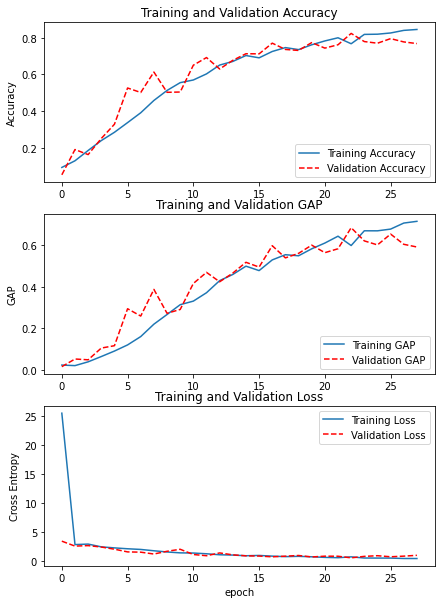

In [ ]:
plot_history(history_fine)